In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def imshow(img, title=""):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [ ]:
# Define CNN Model
class OCR_CNN(nn.Module):
    def __init__(self):
        super(OCR_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Load MNIST without augmentations
transform_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_no_aug = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_no_aug)
test_dataset_no_aug = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_no_aug)

dataloader_no_aug = torch.utils.data.DataLoader(dataset_no_aug, batch_size=64, shuffle=True)
test_dataloader_no_aug = torch.utils.data.DataLoader(test_dataset_no_aug, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.15MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.79MB/s]


In [ ]:
# Load MNIST with augmentations
transform_aug = transforms.Compose([
    transforms.RandomRotation(20),  # Increase rotation degree
    transforms.RandomAffine(0, translate=(0.2, 0.2)), # Increase translation range
    transforms.RandomResizedCrop(28, scale=(0.8, 1.2)), # Random resizing
    transforms.RandomHorizontalFlip(), # Random horizontal flipping
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_aug = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_aug)
test_dataset_aug = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_aug)

dataloader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=64, shuffle=True)
test_dataloader_aug = torch.utils.data.DataLoader(test_dataset_aug, batch_size=64, shuffle=False)

In [ ]:
# Train the Model

def train(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader):.4f}")

# Evaluate Model

def evaluate(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

In [ ]:
# Train and Evaluate Without Augmentation
print("Training on MNIST without augmentations")
model_no_aug = OCR_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_no_aug.parameters(), lr=0.001)
train(model_no_aug, dataloader_no_aug, criterion, optimizer, epochs=5)
evaluate(model_no_aug, test_dataloader_no_aug)

Training on MNIST without augmentations
Epoch 1, Loss: 0.2741
Epoch 2, Loss: 0.0991
Epoch 3, Loss: 0.0725
Epoch 4, Loss: 0.0599
Epoch 5, Loss: 0.0510
Accuracy: 99.21%


In [ ]:
# Train and Evaluate With Augmentation
print("Training on MNIST with augmentations")
model_aug = OCR_CNN()
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)
train(model_aug, dataloader_aug, criterion, optimizer, epochs=5)
evaluate(model_aug, test_dataloader_aug)

Training on MNIST with augmentations
Epoch 1, Loss: 1.2765
Epoch 2, Loss: 0.8530
Epoch 3, Loss: 0.7334
Epoch 4, Loss: 0.6406
Epoch 5, Loss: 0.5759
Accuracy: 90.23%


In [ ]:
# Visualizing 9 images from test set with predictions
def visualize_predictions(model, test_dataloader, title="Predictions"):
    model.eval()
    images, labels = next(iter(test_dataloader))
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    fig.suptitle(title, fontsize=14)
    for i, ax in enumerate(axes.flat):
        img = images[i] / 2 + 0.5  # Unnormalize
        img = img.numpy()
        ax.imshow(np.transpose(img, (1, 2, 0)), cmap='gray')
        ax.set_title(f"Pred: {predicted[i].item()}")
        ax.axis("off")
    plt.show()

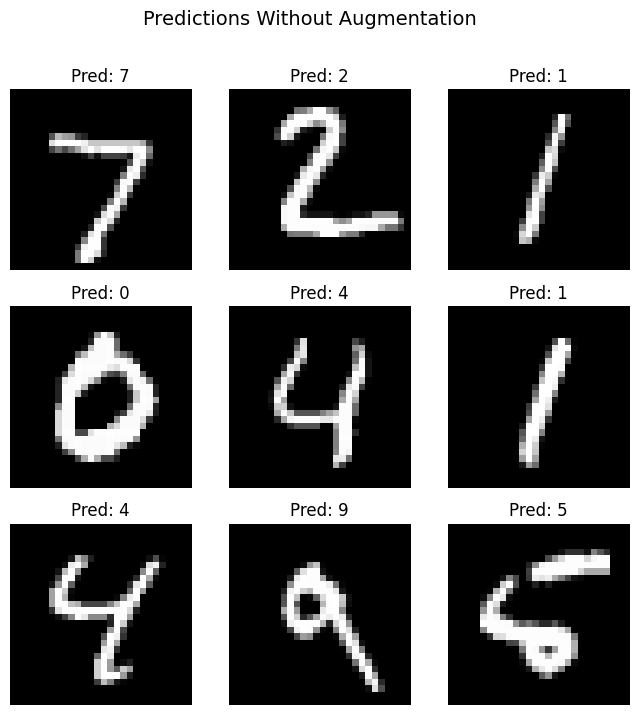

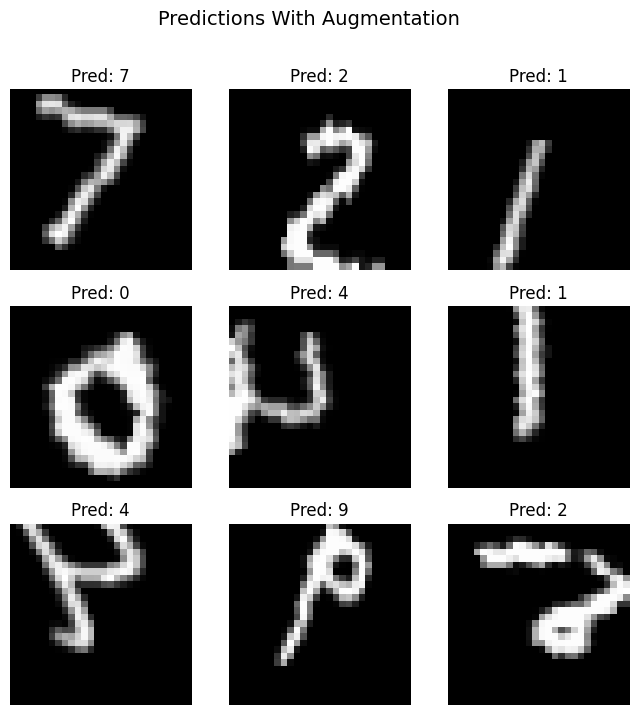

In [ ]:
visualize_predictions(model_no_aug, test_dataloader_no_aug, "Predictions Without Augmentation")
visualize_predictions(model_aug, test_dataloader_aug, "Predictions With Augmentation")